# Teaser

This notebook creates an explainer figure for the documentation and paper.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import lensed_umap as lu

from umap import UMAP
import matplotlib.pyplot as plt
from matplotlib import colors as cl
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Arc, Ellipse
from matplotlib.collections import PatchCollection, LineCollection

from lib.plotting import *

configure_matplotlib()
blues = highpassColors("Blues", 0.2)

## Data

The data contains 2D positions and 1 lens dimension.

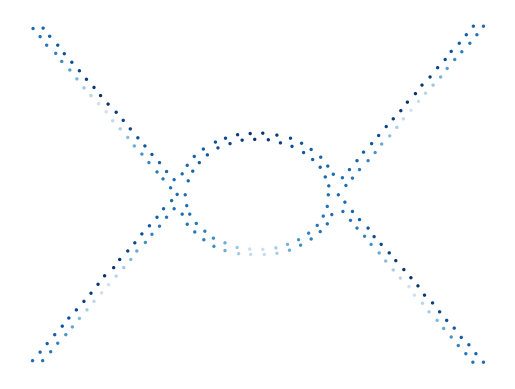

In [17]:
df = pd.read_csv("./data/five_circles.csv", header=0)
lens = np.log(df.hue)

plt.scatter(df.x, df.y, 2, lens, cmap=blues)
plt.axis("off")
plt.show()

## Lenses
Compute the three lens types and store additional info for the figures. 

In [18]:
# Construct UMAP graph
projector = UMAP(repulsion_strength=0.1, negative_sample_rate=2).fit(df[["x", "y"]])
regular_lensed, regular_bins = lu.apply_lens(
    projector, lens, discretization="regular", resolution=6, ret_bins=True
)
local_masked = lu.apply_local_mask(projector, lens, n_neighbors=6)

c:\Users\jelme\micromamba\envs\work\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Helpers

Helper functions and control variables for drawing common elements in the figure.

In [19]:
arc_width = 0.1
local_arc_width = 0.4
keep_arc_color = "k"  # "#6E3C08"
remove_arc_color = "#E51700" #"silver"
keep_arc_alpha = 0.3
remove_arc_alpha = 0.04
local_keep_arc_alpha = 1
local_remove_arc_alpha = 0.4

node_size = 20
node_cmap = blues
edge_width = 0.3
edge_alpha = 0.2
edge_color = keep_arc_color

boundary_linetype = ":"
boundary_colour = "k"
boundary_width = 0.5

In [20]:
def draw_nodes(projector, lens, size=None):
    if size is None:
        size = node_size
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    plt.scatter(
        (x - ix) / (ax - ix),
        (y - iy) / (ay - iy),
        size,
        lens,
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        marker=".",
        edgecolors="none",
        linewidths=0,
    )


def draw_edges(
    projector, edge_width=edge_width, edge_alpha=edge_alpha, edge_color=edge_color
):
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    x = (x - ix) / (ax - ix)
    y = (y - iy) / (ay - iy)
    edges = projector.graph_.tocoo()
    parents = edges.row.astype("int")
    children = edges.col.astype("int")
    lc = LineCollection(
        list(zip(zip(x[children], y[children]), zip(x[parents], y[parents]))),
        linewidth=edge_width,
        color=edge_color,
        alpha=edge_alpha,
        zorder=-1,
    )
    plt.gca().add_collection(lc)


def draw_lens(lens, alpha=1):
    plt.scatter(
        lens,
        np.zeros(len(lens)),
        40,
        lens,
        marker="|",
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        alpha=alpha,
    )


def draw_boundaries(bins):
    resolution = len(np.unique(bins))
    lower_boundaries = [np.min(lens[bins == b]) for b in range(resolution)]
    upper_boundaries = [np.max(lens[bins == b]) for b in range(resolution)]
    boundaries = [
        (l + u) / 2 for l, u in zip(lower_boundaries[1:], upper_boundaries[:-1])
    ]
    for b in boundaries:
        plt.plot(
            [b, b],
            [-0.15, 0.5],
            boundary_linetype,
            color=boundary_colour,
            linewidth=boundary_width,
        )


def draw_arcs_for_point(projector, lens, idx, n_neighbors=None):
    start_idx = projector.graph_.indptr[idx]
    end_idx = projector.graph_.indptr[idx + 1]
    columns = projector.graph_.indices[start_idx:end_idx]
    distances = np.abs(lens[idx] - lens[columns])
    columns = columns[np.argsort(distances)]
    if n_neighbors is None:
        n_neighbors = len(columns)
    plt.text(
        lens[idx] - 0.03,
        -0.05,
        "$\\uparrow$ per point",
        va="top",
        ha="left",
        fontsize=8,
    )
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.05],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 3.5,
                    theta2=180.0,
                    alpha=local_remove_arc_alpha,
                    color=remove_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors, len(columns))
            ],
            match_original=True,
        )
    )
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.05],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 3.5,
                    theta2=180.0,
                    alpha=local_keep_arc_alpha,
                    color=keep_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors)
            ],
            match_original=True,
        )
    )


def draw_filtered_arcs(projector, result, lens, flipped=False):
    g1 = projector.graph_.copy()
    g1.data[:] = 1
    g2 = result.graph_.copy()
    g2.data[:] = 1

    remove_edges = g1 - g2
    remove_edges.eliminate_zeros()
    keep_edges = g1 - remove_edges
    keep_edges.eliminate_zeros()

    projector_keep = []
    projector_remove = []

    direction = 1 - (flipped * 2)

    for row in range(len(lens)):
        start_idx = remove_edges.indptr[row]
        end_idx = remove_edges.indptr[row + 1]
        for col in remove_edges.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_remove.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.05],
                    2 * radius,
                    direction * min(radius, 0.49),
                    theta2=180.0,
                    alpha=remove_arc_alpha,
                    color=remove_arc_color,
                    linewidth=arc_width,
                )
            )

        start_idx = keep_edges.indptr[row]
        end_idx = keep_edges.indptr[row + 1]
        for col in keep_edges.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_keep.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.05],
                    2 * radius,
                    direction * min(radius, 0.49),
                    theta2=180.0,
                    alpha=keep_arc_alpha,
                    color=keep_arc_color,
                    linewidth=arc_width,
                )
            )

    plt.gca().add_collection(PatchCollection(projector_remove, match_original=True))
    plt.gca().add_collection(PatchCollection(projector_keep, match_original=True))


def draw_arcs(
    projector, lens, flipped=False, arc_width=arc_width, arc_alpha=keep_arc_alpha
):
    projector_keep = []
    direction = 1 - (flipped * 2)
    for row in range(len(lens)):
        start_idx = projector.graph_.indptr[row]
        end_idx = projector.graph_.indptr[row + 1]
        for col in projector.graph_.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_keep.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.05],
                    2 * radius,
                    direction * min(radius, 0.49),
                    theta2=180.0,
                    alpha=arc_alpha,
                    color=keep_arc_color,
                    linewidth=arc_width,
                )
            )
    plt.gca().add_collection(PatchCollection(projector_keep, match_original=True))

## Draw
The code that draws the figure:

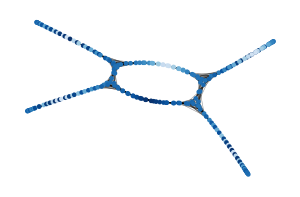

In [21]:
sized_fig(0.33)
draw_nodes(projector, lens)
draw_edges(projector)
xlim = plt.xlim()
ylim = plt.ylim()
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./figures/initial_model_result.png", dpi=600, pad_inches=0)
plt.show()

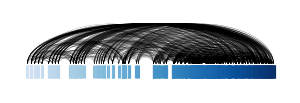

In [22]:
sized_fig(0.33, 0.3)
draw_lens(lens)
draw_arcs(projector, lens)
plt.ylim(-.1, 0.35)
plt.axis("off")
plt.subplots_adjust(0, 0.10, 1, 1)
plt.savefig("./figures/initial_model_filter.png", dpi=600, pad_inches=0)
plt.show()

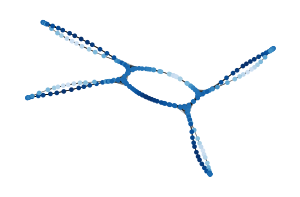

In [23]:
sized_fig(0.33)
draw_nodes(regular_lensed, lens)
draw_edges(regular_lensed)
plt.xlim(ylim)
plt.ylim(xlim)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./figures/global_lens_result.png", dpi=600, pad_inches=0)
plt.show()

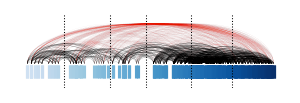

In [24]:
sized_fig(0.33, 0.3)
draw_lens(lens)
draw_filtered_arcs(projector, regular_lensed, lens)
draw_boundaries(regular_bins)
plt.ylim(-.1, 0.35)
plt.axis("off")
plt.subplots_adjust(0, 0.10, 1, 1)
plt.savefig("./figures/global_lens_filter.png", dpi=600, pad_inches=0)
plt.show()

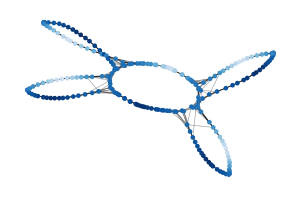

In [25]:
sized_fig(0.33)
draw_nodes(local_masked, lens)
draw_edges(local_masked)
plt.xlim(ylim)
plt.ylim(xlim)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./figures/local_mask_result.png", dpi=600, pad_inches=0)
plt.show()

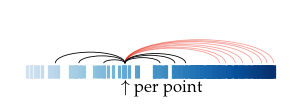

In [26]:
sized_fig(0.33, 0.3)
draw_lens(lens)
draw_arcs_for_point(projector, lens, np.argpartition(lens, 45)[45], n_neighbors=6)
plt.ylim(-.1, 0.35)
plt.axis("off")
plt.subplots_adjust(0, 0.10, 1, 1)
plt.savefig("./figures/local_mask_filter.png", dpi=600, pad_inches=0)
plt.show()